# Synthetic Reference Notebook

Questions:

- Maximum Likelihood Estimation vs Maximum A Priori Estimation
- Clarification on "small data regime"

In [10]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import ssm
from ssm.util import find_permutation


npr.seed(0)

In [11]:
# input dimensions:
# 1: stimulus conditions
# 2: previous choice
# 3: win-stay lose-switch
# 4: stimulus bias

In [12]:
n_sessions = 20
n_trials = 100

# static inputs for our case
previous_choice = np.ones((n_sessions, n_trials, 1))
wsls = np.ones((n_sessions, n_trials, 1))
bias = np.ones((n_sessions, n_trials, 1))

# randomly choose one of the conditions in a numpy of shape (20, 200, 1)
conditions = [0, 1, 2, 3]
stimulus_conditions = npr.choice(conditions, size=(n_sessions, n_trials, 1))
unique, count = np.unique(stimulus_conditions.reshape(-1), return_counts=True)
print("stimulus conditions: ", " ".join([f"{u}:{c}" for u, c in zip(unique, count)]))

stimulus conditions:  0:507 1:507 2:474 3:512


In [13]:
covariates = np.concatenate((stimulus_conditions, previous_choice, wsls, bias), axis=2)
covariates.shape, covariates[0, 0, :]

((20, 100, 4), array([0., 1., 1., 1.]))

In [14]:
# true choices
model_choices = np.copy(stimulus_conditions)
model_choices[model_choices == 0] = 1
model_choices[model_choices == 1] = 0
model_choices[model_choices == 2] = 0
model_choices[model_choices == 3] = 1

# randomly flip some choices from 0 to 1 and vice versa
# 10% of the time

for i in range(n_sessions):
    for j in range(n_trials):
        if npr.rand() < 0.001:
            model_choices[i, j, 0] = 1 - model_choices[i, j, 0]

model_choices.shape

(20, 100, 1)

In [15]:
np.unique((model_choices == stimulus_conditions)).mean()

0.5

In [ ]:
# Set the parameters of the GLM-HMM
num_states = 3        # number of discrete states - state guess
obs_dim = 1           # number of observed dimensions (model choices output - single value) n_final layer output dimentions
num_categories = 2    # number of categories for output (binary model choice)
input_dim = 4         # input dimensions (stimulus conditions, previous choice, wsls, bias)

# Make a GLM-HMM
glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                 observation_kwargs=dict(C=num_categories), transitions="standard")

N_iters = 200
### CHECK THIS: BOTH CHOICES AND COVARIATES NEED TO LISTS OF NDARRAYS
fit_ll = glmhmm.fit([x for x in model_choices], inputs=[x for x in covariates], method="em", num_iters=N_iters, tolerance=10**-4)

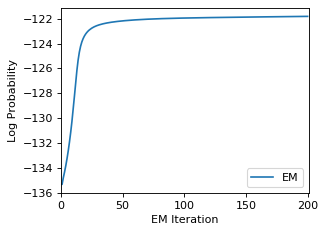

In [9]:
# Plot the log probabilities of the true and fit models. Fit model final LL should be greater 
# than or equal to true LL.
fig = plt.figure(figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
plt.plot(fit_ll, label="EM")
plt.legend(loc="lower right")
plt.xlabel("EM Iteration")
plt.xlim(0, len(fit_ll))
plt.ylabel("Log Probability")
plt.show()

In [10]:
# Posterior State Probabilities
# Get expected states:
posterior_probs = [glmhmm.expected_states(data=data, input=inpt)[0]
                for data, inpt
                in zip([x for x in model_choices], 
                       [x for x in covariates])]

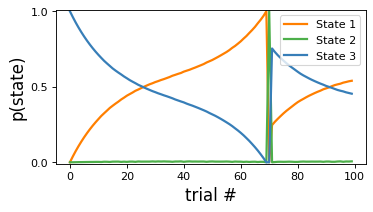

In [16]:
cols = ['#ff7f00', '#4daf4a', '#377eb8']
fig = plt.figure(figsize=(5, 2.5), dpi=80, facecolor='w', edgecolor='k')
sess_id = 0 #session id; can choose any index between 0 and num_sess-1
for k in range(num_states):
    plt.plot(posterior_probs[sess_id][:, k], label="State " + str(k + 1), lw=2,
             color=cols[k])
plt.ylim((-0.01, 1.01))
plt.yticks([0, 0.5, 1], fontsize = 10)
plt.xlabel("trial #", fontsize = 15)
plt.ylabel("p(state)", fontsize = 15)
plt.legend(loc="upper right", fontsize = 10)
plt.show()

In [17]:
# concatenate posterior probabilities across sessions
posterior_probs_concat = np.concatenate(posterior_probs)
# get state with maximum posterior probability at particular trial:
state_max_posterior = np.argmax(posterior_probs_concat, axis = 1)
# now obtain state fractional occupancies:
_, state_occupancies = np.unique(state_max_posterior, return_counts=True)
state_occupancies = state_occupancies/np.sum(state_occupancies)

Text(0, 0.5, 'frac. occupancy')

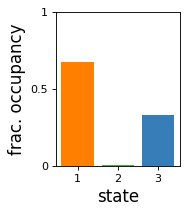

In [18]:
fig = plt.figure(figsize=(2, 2.5), dpi=80, facecolor='w', edgecolor='k')
for z, occ in enumerate(state_occupancies):
    plt.bar(z, occ, width = 0.8, color = cols[z])
plt.ylim((0, 1))
plt.xticks([0, 1, 2], ['1', '2', '3'], fontsize = 10)
plt.yticks([0, 0.5, 1], ['0', '0.5', '1'], fontsize=10)
plt.xlabel('state', fontsize = 15)
plt.ylabel('frac. occupancy', fontsize=15)

In [21]:
mle_weights = glmhmm.observations.params
mle_log_trans_mat = glmhmm.transitions.params

Text(0.5, 1.0, 'Generative transition matrix')

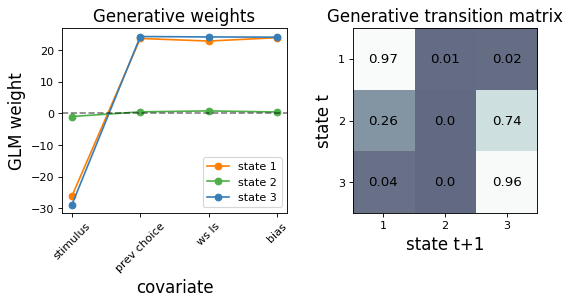

In [26]:
# Plot MLE parameters:
fig = plt.figure(figsize=(8, 3), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
cols = ['#ff7f00', '#4daf4a', '#377eb8']
for k in range(num_states):
    plt.plot(range(input_dim), mle_weights[k][0], marker='o',
             color=cols[k], linestyle='-',
             lw=1.5, label="state " + str(k+1))
plt.yticks(fontsize=10)
plt.ylabel("GLM weight", fontsize=15)
plt.xlabel("covariate", fontsize=15)
plt.xticks([0, 1, 2, 3], ['stimulus', 'prev choice', 'ws ls', 'bias'], fontsize=10, rotation=45)
plt.axhline(y=0, color="k", alpha=0.5, ls="--")
plt.legend()
plt.title("Generative weights", fontsize = 15)

plt.subplot(1, 2, 2)
gen_trans_mat = np.exp(mle_log_trans_mat)[0]
plt.imshow(gen_trans_mat, vmin=-0.8, vmax=1, cmap='bone')
for i in range(gen_trans_mat.shape[0]):
    for j in range(gen_trans_mat.shape[1]):
        text = plt.text(j, i, str(np.around(gen_trans_mat[i, j], decimals=2)), ha="center", va="center",
                        color="k", fontsize=12)
plt.xlim(-0.5, num_states - 0.5)
plt.xticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.yticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.ylim(num_states - 0.5, -0.5)
plt.ylabel("state t", fontsize = 15)
plt.xlabel("state t+1", fontsize = 15)
plt.title("Generative transition matrix", fontsize = 15)